In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import datetime
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase', 'first_issue_date'])
purchases.transaction_datetime =  pd.to_datetime(purchases.transaction_datetime).dt.date
purchases.first_issue_date =  pd.to_datetime(purchases.first_issue_date).dt.date
purchases['days'] = ((purchases.transaction_datetime - purchases.first_issue_date) / datetime.timedelta(days=1)).astype(int)
purchases['weeks'] = purchases['days'] // 7 + 1
purchases = purchases.groupby(['client_id', 'transaction_datetime', 'weeks']).agg({'sum_purchase': 'sum'}).reset_index()
purchases = purchases[purchases.weeks > 0].reset_index(drop=True)

In [113]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'age', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

In [114]:
ppp = purchases[['client_id', 'weeks', 'sum_purchase']]
ppp = ppp.groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()

In [8]:
ppp.head()

,client_id,weeks,sum_purchase
0,000012768d,70,1007
1,000012768d,72,575
2,000012768d,83,804
3,000012768d,84,419
4,000036f903,86,241


In [115]:
ppp = pd.merge(ppp, clients[['client_id', 'age', 'gender']], on='client_id', how='left').iloc[:, 1:]

In [13]:
ppp.head()

,weeks,sum_purchase,age,gender
0,70,1007,45,U
1,72,575,45,U
2,83,804,45,U
3,84,419,45,U
4,86,241,72,F


In [109]:
sns.set_theme(style="darkgrid")

In [116]:
ppp_ = ppp[(ppp.weeks == 1) & (ppp.age > 16) & (ppp.age < 80)].groupby('age').sum_purchase.mean().reset_index()
ppp_2 = ppp[(ppp.age > 16) & (ppp.age < 80)].groupby('age').sum_purchase.mean().reset_index()

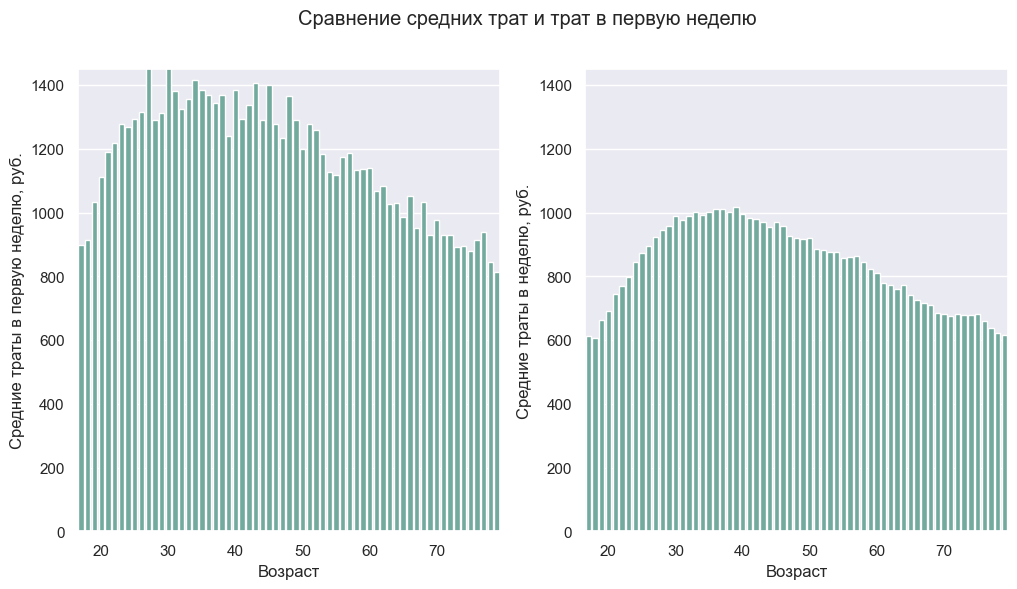

In [126]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.xlabel('Возраст')
plt.ylabel('Средние траты в первую неделю, руб.')
sns.barplot(ppp_, x='age', y='sum_purchase', color='#69b3a2')
plt.ylim(0, 1450)
plt.xticks([3, 13, 23, 33, 43, 53])
plt.subplot(122)
plt.ylim(0, 1450)
plt.xlabel('Возраст')
plt.ylabel('Средние траты в неделю, руб.')
sns.barplot(ppp_2, x='age', y='sum_purchase', color='#69b3a2')
plt.xticks([3, 13, 23, 33, 43, 53])
plt.suptitle('Сравнение средних трат и трат в первую неделю')
plt.show()

Визуально на двух иллюстрациях можем видеть, что общий паттерн зависимости недельной траты от возраста сохраняется и в первую неделю использования карты лояльности: клиенты возраста 30-40 показывают максимальные показатели, затем следует постепенный спад. Хочется измерить этот эффект для каждой возрастной группы.

In [8]:
df_ = pd.merge(ppp_, ppp_2, on='age')
df_['diff'] = df_.iloc[:, 1] - df_.iloc[:, 2]
df_['ratio'] = (df_.iloc[:, 1] / df_.iloc[:, 2] - 1) * 100

Нам открывается тот факт, что выраженный в рублях эффект от первой недели в процентах меняет паттерн: наибольший относительный прирост в первую неделю показывают клиенты 20-25 лет, а клиенты 30-40 лет, наоборот, демонстрируют довольно скромные показатели прироста. Это может свидетельствовать о том, что молодые клиенты наиболее предрасположены к использованию дополнительных преимуществ карт лояльности, в то время как клиенты среднего возраста не готовы тратить значительно большие суммы из-за того, что их обычные траты являются значительными.

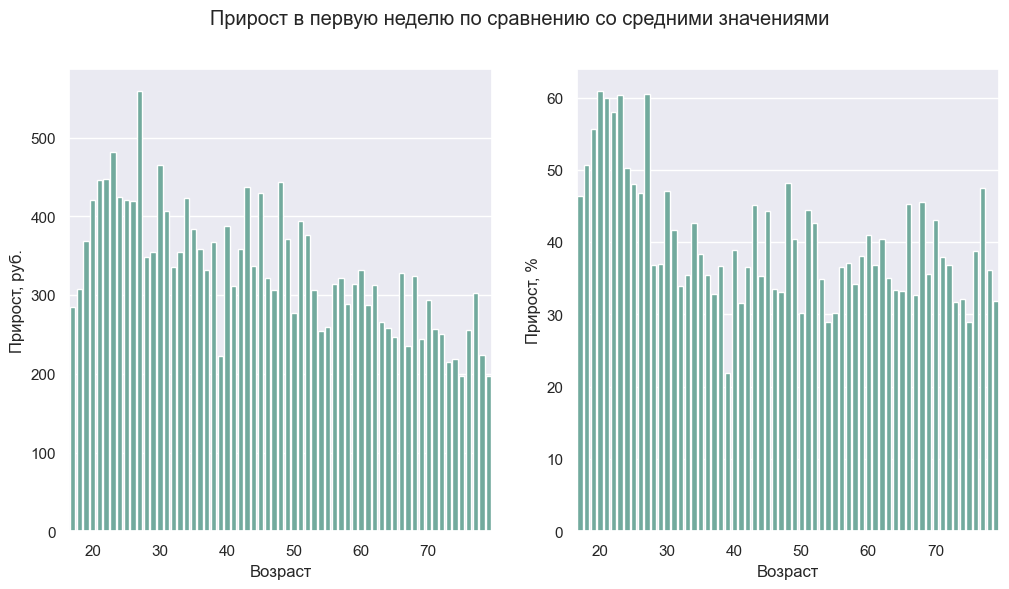

In [129]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.barplot(df_, x='age', y='diff', color='#69b3a2')
plt.xticks([3, 13, 23, 33, 43, 53])
plt.xlabel('Возраст')
plt.ylabel('Прирост, руб.')
plt.subplot(122)
sns.barplot(df_, x='age', y='ratio', color='#69b3a2')
plt.xlabel('Возраст')
plt.ylabel('Прирост, %')
plt.xticks([3, 13, 23, 33, 43, 53])
plt.suptitle('Прирост в первую неделю по сравнению со средними значениями')
plt.show()

Рассмотрим те же графики, специфицируя их по гендеру.

In [10]:
ppp_ = ppp[(ppp.weeks == 1) & (ppp.age > 16) & (ppp.age < 80)].groupby(['age', 'gender']).sum_purchase.mean().reset_index()
ppp_2 = ppp[(ppp.age > 16) & (ppp.age < 80)].groupby(['age', 'gender']).sum_purchase.mean().reset_index()

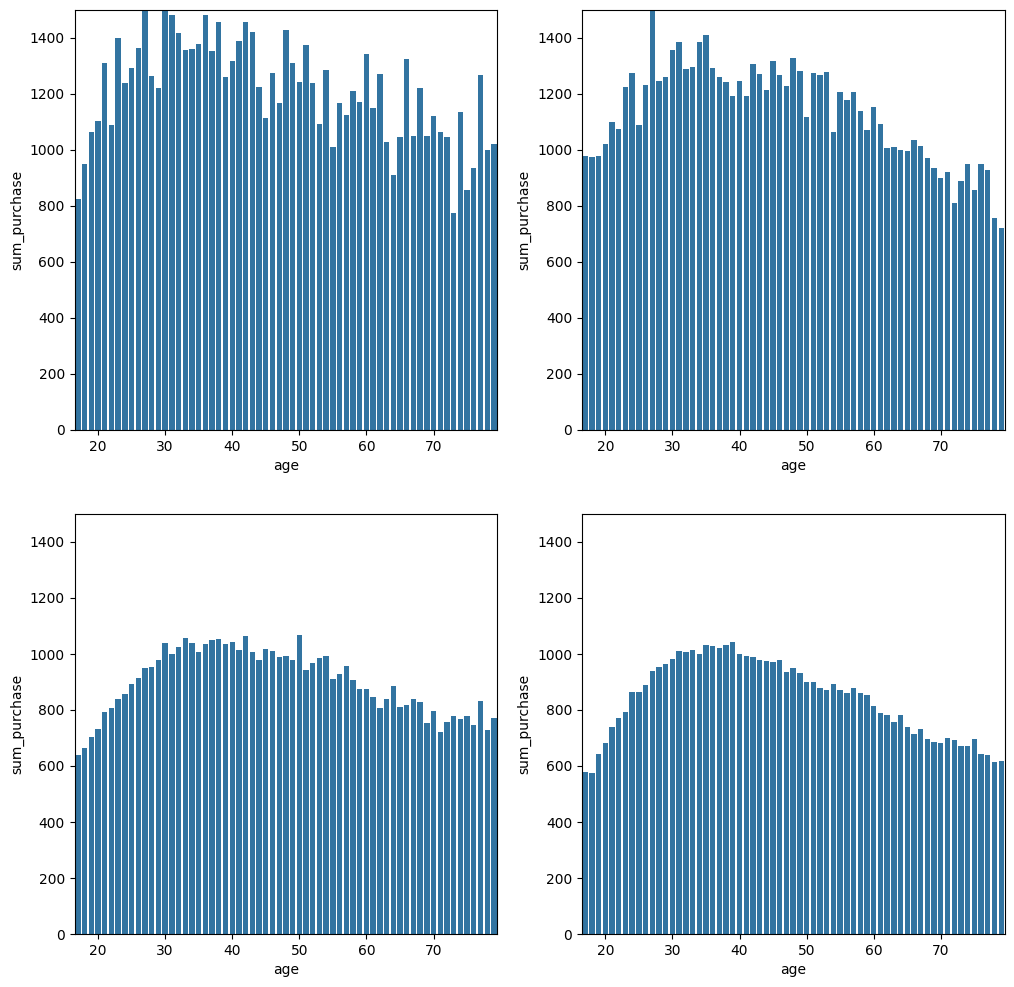

In [11]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.barplot(ppp_[ppp_.gender == 'M'], x='age', y='sum_purchase')
plt.ylim(0, 1500)
plt.xticks([3, 13, 23, 33, 43, 53])
plt.subplot(222)
sns.barplot(ppp_[ppp_.gender == 'F'], x='age', y='sum_purchase')
plt.ylim(0, 1500)
plt.xticks([3, 13, 23, 33, 43, 53])
plt.subplot(223)
plt.ylim(0, 1500)
sns.barplot(ppp_2[ppp_.gender == 'M'], x='age', y='sum_purchase')
plt.xticks([3, 13, 23, 33, 43, 53])
plt.subplot(224)
plt.ylim(0, 1500)
sns.barplot(ppp_2[ppp_.gender == 'F'], x='age', y='sum_purchase')
plt.xticks([3, 13, 23, 33, 43, 53])
plt.show()

Оценивая исключительно визуально, мы можем сказать, что средние расходы в неделю для мужчин и женщин фактически не отличаются. В то же время значения в первую неделю для мужчин по некоторым возрастным группам демонстрируется больший перфоманс. Это может быть достаточно интересным, однако данный эффект надо уловить статистически.

In [12]:
table1 = purchases[purchases.weeks == 1].groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()
table1 = table1[['client_id', 'sum_purchase']]

In [13]:
table2 = purchases[purchases.client_id.isin(table1.client_id)][['client_id', 'sum_purchase', 'weeks']]
table2 = table2.groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()
table2 = table2.groupby(['client_id']).sum_purchase.mean().reset_index()
table2.sum_purchase = table2.sum_purchase.astype(int)

In [14]:
table1 = pd.merge(table1, table2, on='client_id', how='left')
table1['diff'] = table1.iloc[:, 1] - table1.iloc[:, 2]
table1['ratio'] = (table1.iloc[:, 1] / table1.iloc[:, 2] - 1) * 100

In [15]:
table1 = pd.merge(table1[['client_id', 'diff', 'ratio']], clients[['client_id', 'age', 'gender']], on='client_id', how='left')

In [16]:
table1 = table1[(table1.age > 16) & (table1.age < 80)]

Видим, что в нашем датафрейме очень много нулей. Это те клиенты, которые совершили покупку только на первой неделе: для них средние траты в неделю равны тратам в первую неделю.

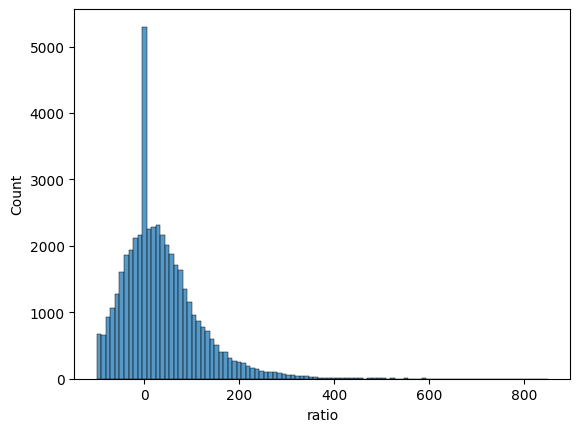

In [17]:
sns.histplot(table1, x='ratio',  bins=100)
plt.show()

Их не так много, поэтому удалим.

In [95]:
table1[(table1.ratio == 0)]

,client_id,diff,ratio,age,gender
14,00140e5d34,0,0.0,50,F
24,00220fd087,0,0.0,47,U
66,0077545e51,0,0.0,41,U
88,00963d21b0,0,0.0,27,U
89,00978b8cac,0,0.0,49,M
...,...,...,...,...,...
48105,ffecc10e9d,0,0.0,40,F
48109,fff3113d7a,0,0.0,37,M
48110,fff3453dff,0,0.0,33,U
48113,fff73c7cc8,0,0.0,31,M


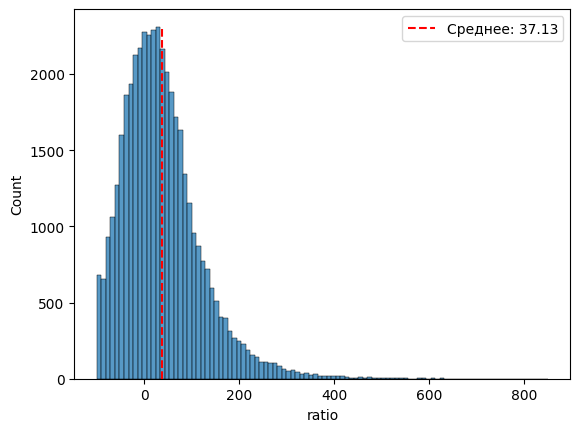

In [28]:
sns.histplot(table1[(table1.ratio != 0)], x='ratio',  bins=100)
m = table1[(table1.ratio != 0)].ratio.mean()
plt.vlines(m, ymin=0, ymax=2300, label=f'Среднее: {m:.2f}', color='r', linestyle='--')
plt.legend()
plt.show()

In [19]:
table1.ratio.min()

-100.0

In [30]:
mu = round(table1[(table1.ratio != 0)].ratio.median(), 2)
std_ = round(table1[(table1.ratio != 0)].ratio.std(), 2)

In [107]:
sample = np.random.normal(loc=mu-23, scale=std_+27, size=10000)
sample = sample[sample > -100]

In [108]:
print(np.round(sample.mean(), 2), np.round(m, 2))
print(np.round(np.median(sample)), mu)
print(np.round(sample.std(), 2), std_)

37.22 37.13
28.0 25.32
85.03 82.82


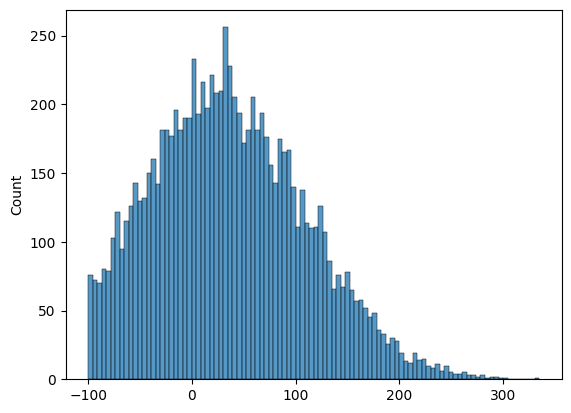

In [32]:
sns.histplot(sample, bins=100)
plt.show()

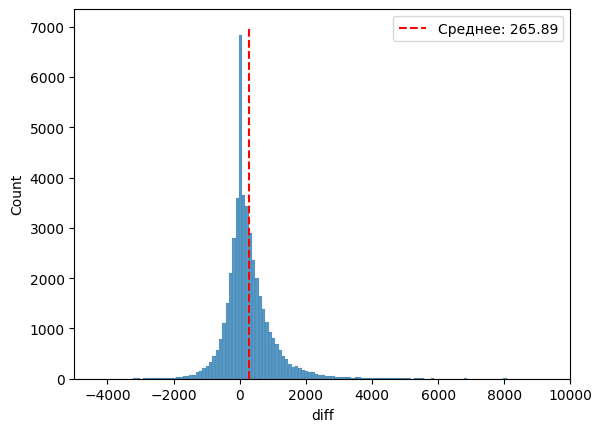

In [110]:
sns.histplot(table1, x='diff',  binwidth=100)
m = table1['diff'].mean()
plt.vlines(m, ymin=0, ymax=7000, label=f'Среднее: {m:.2f}', color='r', linestyles='--')
plt.legend()
plt.xlim(-5000, 10000)
plt.show()

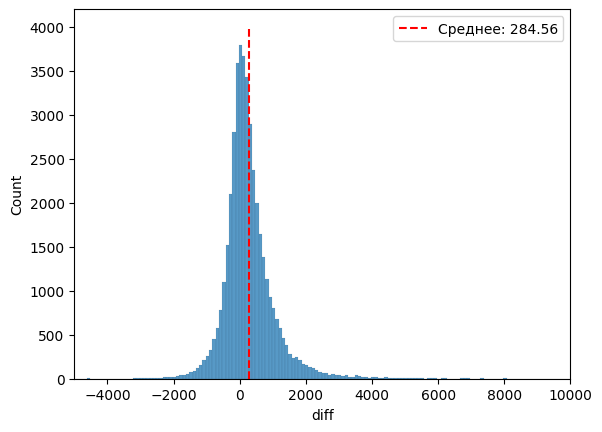

In [112]:
sns.histplot(table1[table1['diff'] != 0], x='diff',  binwidth=100)
m = table1[table1['diff'] != 0]['diff'].mean()
plt.vlines(m, ymin=0, ymax=4000, label=f'Среднее: {m:.2f}', color='r', linestyles='--')
plt.legend()
plt.xlim(-5000, 10000)
plt.show()

Также видим значительную асимметрию распределения.

In [115]:
print("Коэффициент асимметрии:", round(scipy.stats.skew(table1[table1['diff'] != 0]['diff']), 2))

Коэффициент асимметрии: 15.72


Корреляции с возрастом нет, визуально на scatterplot также видно, что хаотично расположены половозрастные показатели.

In [77]:
table1[['age', 'diff', 'ratio']].corr()

,age,diff,ratio
age,1.000000,-0.010546,0.024515
diff,-0.010546,1.000000,0.672278
ratio,0.024515,0.672278,1.000000


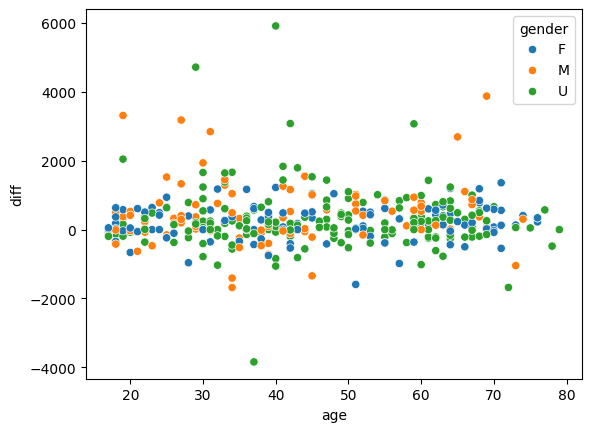

In [81]:
sns.scatterplot(table1.sample(400), x='age', y='diff', hue='gender')
plt.show()